In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [68]:

from torchvision.datasets import MNIST
from torchvision import transforms

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [6]:
!cd

c:\Users\Vedant\Downloads


In [70]:
!tar xvzf "c:\Users\Vedant\Downloads\CUB_200_2011.tgz"

^C


In [71]:
with open('c:/Users/Vedant/Downloads/CUB_200_2011/images.txt') as file:
    images_path = [line.rstrip().split(" ")[1] for line in file]

In [72]:
len(images_path)

11788

In [73]:

with open('c:/Users/Vedant/Downloads/CUB_200_2011/train_test_split.txt') as file:
    train_id=[]
    test_id=[]
    train_test=[]
    for line in file:
      if(int(line.rstrip().split(" ")[1])==1):
        train_id.append(images_path[int(line.rstrip().split(" ")[0])-1])
      else:
        test_id.append(images_path[int(line.rstrip().split(" ")[0])-1])
      train_test.append(int(line.rstrip().split(" ")[1]))


In [74]:
test_id[0]

'001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'

In [75]:
from PIL import Image
import random
import cv2 

img = Image.open('c:/Users/Vedant/Downloads/CUB_200_2011/images/'+train_id[random.randint(0, len(train_id))])
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]
img=img.crop((left, upper, right, bottom))
img.show('image',img)

TypeError: show() takes from 1 to 2 positional arguments but 3 were given

In [76]:
with open('c:/Users/Vedant/Downloads/CUB_200_2011/image_class_labels.txt') as file:
    train_label=[]
    test_label=[]
    for line in file:
      if(train_test[int(line.rstrip().split(" ")[0])-1]==1):
        train_label.append(int(line.rstrip().split(" ")[1])-1)
      else:
        test_label.append(int(line.rstrip().split(" ")[1])-1)

In [77]:
from numpy import asarray

In [78]:
def make_sample(n_way,n_support,n_query,x,y):
  sample=[]
  x=np.array(x)
  y=np.array(y)
  k=np.random.choice(np.unique(y), n_way, replace=True)
  
  newsize=(84,84)
  frac = 0.75
    
  for label in k:
    data=x[y==label]
    perm = np.random.permutation(data)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
    
  # images = [[None for j in range(n_support+n_query)] for i in range(n_way)]
  images = np.zeros([n_way,n_support+n_query,newsize[0],newsize[1],3])
  for i in range(n_way):
    c=0
    for path in sample[i]:
        with Image.open('c:/Users/Vedant/Downloads/CUB_200_2011/images/'+path) as img:
          
            left = img.size[0]*((1-frac)/2)
            upper = img.size[1]*((1-frac)/2)
            right = img.size[0]-((1-frac)/2)*img.size[0]
            bottom = img.size[1]-((1-frac)/2)*img.size[1]
            img=img.crop((left, upper, right, bottom))
            img = img.resize(newsize)
            img = img.convert("RGB")
            images[i][c]=asarray(img)
            
        c+=1;
    
  images = np.array(images)
  images=torch.from_numpy(images).float()
  images = images.permute(0,1,4,2,3)
  return ({
      'images': images,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [79]:

sample_example = make_sample(4, 3,3, train_id, train_label)
print(sample_example['images'][0][0])

tensor([[[180., 194., 181.,  ..., 150., 121., 107.],
         [148., 186., 178.,  ..., 148., 130., 109.],
         [110., 142., 172.,  ..., 144., 123., 118.],
         ...,
         [105., 109., 159.,  ..., 156., 171., 183.],
         [105., 105., 157.,  ..., 146., 140., 165.],
         [104., 111., 176.,  ..., 153., 146., 165.]],

        [[153., 161., 154.,  ..., 132., 135., 125.],
         [123., 156., 151.,  ..., 128., 136., 126.],
         [ 89., 111., 140.,  ..., 117., 126., 132.],
         ...,
         [119., 117., 157.,  ..., 145., 161., 177.],
         [119., 119., 157.,  ..., 123., 116., 156.],
         [119., 123., 176.,  ..., 145., 129., 156.]],

        [[108., 122., 109.,  ...,  91.,  59.,  42.],
         [ 75., 117., 105.,  ...,  87.,  67.,  42.],
         [ 41.,  69.,  94.,  ...,  72.,  58.,  51.],
         ...,
         [ 42.,  49.,  93.,  ...,  73.,  86.,  92.],
         [ 45.,  51., 101.,  ...,  66.,  62.,  76.],
         [ 45.,  54., 111.,  ...,  83.,  72.,  81.]]]

In [80]:
def display_sample(sample):
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  grid = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

  grid_norm = (grid - torch.min(grid)) / (torch.max(grid) - torch.min(grid))
  grid_np = grid_norm.numpy()
  plt.imshow(grid_np.transpose((1, 2, 0)))
  plt.axis('off')
  plt.show()
  # plt.figure(figsize = (16,7))
  # plt.imshow(out.permute(1, 2, 0))

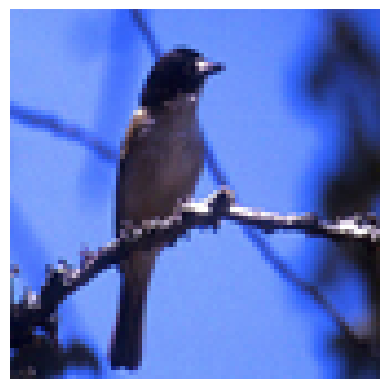

In [82]:
sample_example = make_sample(1, 1,0, train_id, train_label)
# print(len(sample_example['images'][0]))
display_sample(sample_example['images'])

In [83]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    # conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [84]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    # self.encoder = encoder.cuda()
    self.encoder = encoder

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    # sample_images = sample['images'].cuda()
    sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
    # print(x_support.shape)
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    # target_inds = target_inds.cuda()
    target_inds = target_inds
    
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    # print(x.shape)
    z = self.encoder.forward(x)
    # print(x.view(x.size(0), -1).shape)
    z_dim = z.size(-1) #usually 64
    # print(z)
    
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]
    # print(z_proto.shape)
    # print(z_query.shape)
    #compute distances
    # dists = euclidean_dist(z_query, z_proto)

    dists = cosine_sim(z_query, z_proto)
    # print(dists.size())
    # compute probabilities
    log_p_y = F.log_softmax(dists, dim=1).view(n_way, n_query, -1)
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
    # print(loss_val)
    # print(loss_val.item())
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }
     

In [85]:
def cosine_sim(x, y):
  

  # compute the dot product
  dot_product = torch.mm(x, y.t())

  # compute the norm of each vector
  norm_a = torch.norm(x, dim=1)
  norm_b = torch.norm(y, dim=1)

  # compute the cosine similarity
  cos_sim = dot_product / torch.ger(norm_a, norm_b)

  return cos_sim

In [86]:
def euclidean_dist(x, y):
  
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [87]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [88]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.3, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = make_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    #   break
    # break
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [90]:
%%time

model = load_protonet_conv(
    x_dim=(3,15,15),
    hid_dim=128,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 5
n_query = 10

max_epoch = 20
epoch_size = 100

train(model, optimizer, train_id, train_label, n_way, n_support, n_query, max_epoch, epoch_size)

<ipython-input-88-509b7c110a3a>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 -- Loss: 1.4891 Acc: 0.3822


Epoch 2 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2 -- Loss: 1.4517 Acc: 0.4364


Epoch 3 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3 -- Loss: 1.4338 Acc: 0.4692


Epoch 4 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4 -- Loss: 1.4114 Acc: 0.4966


Epoch 5 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5 -- Loss: 1.3953 Acc: 0.5252


Epoch 6 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6 -- Loss: 1.4056 Acc: 0.4986


Epoch 7 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7 -- Loss: 1.4061 Acc: 0.5014


Epoch 8 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8 -- Loss: 1.4096 Acc: 0.5038


Epoch 9 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9 -- Loss: 1.4171 Acc: 0.4900


Epoch 10 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10 -- Loss: 1.3984 Acc: 0.5140


Epoch 11 train:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [71]:
model = load_protonet_conv(
    x_dim=(3,64,64),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)
model.load_state_dict(torch.load('c:/Users/Vedant/Downloads/cub_proto_model.pt'))
optimizer.load_state_dict(torch.load('c:/Users/Vedant/Downloads/cub_proto_optimizer.pt'))

In [47]:
print(torch.cuda.device_count())   # --> 0
print(torch.cuda.is_available())   # --> False
print(torch.version.cuda) 

0
False
None


In [91]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):

  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = make_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [111]:
n_way = 5
n_support = 5
n_query = 5

test_episode = 500

test(model, test_id, test_label, n_way, n_support, n_query, test_episode)

<ipython-input-91-1034a9658d73>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/500 [00:00<?, ?it/s]

Test results -- Loss: 1.4146 Acc: 0.4979


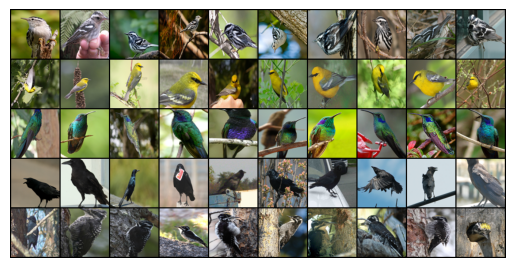

In [127]:
my_sample = make_sample(n_way, n_support, n_query, test_id, test_label)
display_sample(my_sample['images'])

In [125]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [126]:
my_output

{'loss': 1.3253436088562012,
 'acc': 0.47999998927116394,
 'y_hat': tensor([[0, 1, 1, 3, 1],
         [0, 3, 4, 1, 0],
         [2, 2, 2, 2, 2],
         [3, 3, 1, 3, 3],
         [2, 2, 3, 2, 4]])}